In [1]:
!pip install -U -q pip
!pip install -U -q ket-lang numpy plotly matplotlib
!pip install sympy

from typing import Literal


def bloch_sphere(qubit):
    from ket import dump
    import numpy as np
    import plotly.graph_objs as go

    """Retorna a figura de uma esfera de Bloch com estado do qubit marcado na esfera.

    Args:
        qubit (ket.Quant): Estado quântico para marcar na esfera.

    Returns:
        go.Figure: Figura com a esfera de Bloch para plot.
    """

    assert len(qubit) == 1, "bloch_sphere só pode ser usado com um qubit"

    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    phi, theta = np.meshgrid(phi, theta)
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    sphere = go.Surface(
        x=x, y=y, z=z, showscale=False, opacity=0.02, name="Bloch Sphere"
    )

    equator_theta = np.linspace(0, 2 * np.pi, 100)
    equator_x = np.cos(equator_theta)
    equator_y = np.sin(equator_theta)
    equator_z = np.zeros_like(equator_theta)

    equator = go.Scatter3d(
        x=equator_x,
        y=equator_y,
        z=equator_z,
        mode="lines",
        line=dict(color="gray", width=3),
        opacity=0.1,
        name="Equator",
    )

    z_line = go.Scatter3d(
        x=[0, 0],
        y=[0, 0],
        z=[1, -1],
        mode="lines",
        line=dict(color="gray", width=3),
        opacity=0.1,
        name="z line",
    )

    x_line = go.Scatter3d(
        x=[1, -1],
        y=[0, 0],
        z=[0, 0],
        mode="lines",
        line=dict(color="gray", width=3),
        opacity=0.1,
        name="x line",
    )

    y_line = go.Scatter3d(
        x=[0, 0],
        y=[1, -1],
        z=[0, 0],
        mode="lines",
        line=dict(color="gray", width=3),
        opacity=0.1,
        name="y line",
    )

    basis_points = [
        ([0, 0, 1], "|0⟩"),
        ([0, 0, -1], "|1⟩"),
        ([1, 0, 0], "|+⟩"),
        ([-1, 0, 0], "|‒⟩"),
        ([0, 1, 0], "|i+⟩"),
        ([0, -1, 0], "|i‒⟩"),
    ]

    basis = [
        go.Scatter3d(
            x=[p[0]],
            y=[p[1]],
            z=[p[2]],
            mode="text",
            text=[text],
            textposition="middle center",
            name=text,
        )
        for p, text in basis_points
    ]

    qubit = dump(qubit)

    ket = np.array(
        [
            [qubit.get()[0] if 0 in qubit.get() else 0.0],
            [qubit.get()[1] if 1 in qubit.get() else 0.0],
        ]
    )

    bra = np.conjugate(ket.T)

    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    exp_x = (bra @ X @ ket).item().real
    exp_y = (bra @ Y @ ket).item().real
    exp_z = (bra @ Z @ ket).item().real

    qubit = go.Scatter3d(
        x=[exp_x],
        y=[exp_y],
        z=[exp_z],
        mode="markers",
        marker=dict(size=5, color="red"),
        name="qubit",
    )

    line = go.Scatter3d(
        x=[0, exp_x],
        y=[0, exp_y],
        z=[0, exp_z],
        mode="lines",
        line=dict(color="red", width=3),
        opacity=0.5,
        name="qubit line",
    )

    fig = go.Figure(
        data=[
            sphere,
            qubit,
            line,
            equator,
            x_line,
            y_line,
            z_line,
            *basis,
        ]
    )

    fig.update_layout(
        scene=dict(
            xaxis=dict(
                range=[-1, 1],
                showgrid=False,
                showbackground=False,
                visible=False,
            ),
            yaxis=dict(
                range=[-1, 1],
                showgrid=False,
                showbackground=False,
                visible=False,
            ),
            zaxis=dict(
                range=[-1, 1],
                showgrid=False,
                showbackground=False,
                visible=False,
            ),
            aspectmode="cube",
        ),
        showlegend=False,
    )

    return fig


def print_state(
    *qubits, format: list[Literal["int", "bin"]] | Literal["int", "bin"] | None = None
):
    """
    Imprime o estado do sistema quântico.

    Args:
        *qubits (Quant): Os qubits cujos estados serão impressos.
        format (list[str] | str | None): O formato de impressão para cada qubit. Pode ser uma lista contendo
            "int" ou "bin" para cada qubit, uma string "int" ou "bin" que será aplicada a todos os qubits,
            ou None para usar o formato padrão "bin".

    Raises:
        AssertionError: Se o argumento `format` for uma string diferente de "int" ou "bin", ou se o tamanho da
            lista `format` não for igual ao número de qubits.
    """
    from itertools import accumulate
    from functools import reduce
    from operator import add
    import ket
    from IPython.display import Math, display

    if isinstance(format, str):
        assert format in ["int", "bin"], "format deve ser 'int' ou 'bin'"
        format = [format] * len(qubits)
    elif format is not None:
        assert len(format) == len(qubits), "format deve ter o mesmo tamanho que qubits"
        assert all(
            f in ["int", "bin"] for f in format
        ), "format deve conter apenas 'int' ou 'bin'"
    else:
        format = ["bin"] * len(qubits)

    qubit_len = list(map(len, qubits))
    split_indices = [0] + list(accumulate(qubit_len))

    qubits = reduce(add, qubits)
    qubits = ket.dump(qubits)
    math = []
    for state, amp in qubits.get().items():

        def float_to_math(num: float, is_complex: bool) -> str | None:
            num_str = None
            if abs(num) > 1e-14:

                sqrt_dem_float = 1 / num**2
                sqrt_dem = round(sqrt_dem_float)
                if abs(sqrt_dem - sqrt_dem_float) < 1e-10 and sqrt_dem != 1:
                    num_str = f"\\frac{{{'-' if num < 0.0 else ''}{'i' if is_complex else '1'}}}{{\\sqrt{{{sqrt_dem}}}}}"
                else:
                    round_num = round(num)
                    if abs(round_num - num) > 1e-14:
                        num_str = str(num)
                        if "e" in num_str:
                            num_str = num_str.replace("e", "\\times10^{") + "}"
                    else:
                        num_str = ""
                    if is_complex:
                        num_str += "i"
            return num_str

        real_str = float_to_math(amp.real, False)
        imag_str = float_to_math(amp.imag, True)

        state_str = f"{state:0{len(qubits.qubits)}b}"
        state_str = [
            f"\\left|{state_str[start:end] if fmt == 'bin' else int(state_str[start:end], 2)}\\right>"
            for start, end, fmt in zip(split_indices, split_indices[1:], format)
        ]
        state_str = "".join(state_str)

        if real_str is not None and imag_str is not None:
            math.append(f"({real_str}+{imag_str}i) {state_str}")
        else:
            math.append(f"{real_str if real_str is not None else imag_str} {state_str}")

    display(Math("+".join(math).replace("+-", "-")))

# Programação Quântica com Ket

Neste capítulo, vamos explorar a plataforma de programação quântica Ket, um projeto de código aberto que inclui a biblioteca de tempo de execução *Libket*, o simulador de computação quântica *KBW* e o pacote Python *Ket*. Este último é uma linguagem embarcada em Python que permite a programação e teste de aplicações quânticas de maneira fácil e direta.

:::{admonition} Versão do Ket
:class: note

Embora o Ket esteja pronto para uso, é importante observar que ele está em desenvolvimento ativo e algumas funcionalidades podem mudar nas futuras versões. Este texto baseia-se no uso do Ket 0.7.x.
:::

## Introdução

### Instalação

Se você estiver executando esta página com <i class="fas fa-rocket"></i> **Live Code**, a instalação do Ket ocorre automaticamente quando o ambiente de execução é carregado. Caso esteja utilizando o Notebook <i class="fas fa-download"></i> baixado dessa página ou no <i class="fas fa-rocket"></i> **Binder/Colab**, os comandos de instalação estão presentes na primeira célula deste notebook.

Para integrar o Ket em um projeto externo, você pode instalá-lo através do PyPI com o pacote `ket-lang` usando o pip:

```bash
pip install -U pip
pip install ket-lang
```

### Documentação 

A documentação completa da API do Ket está disponível em https://quantumket.org. Se surgir alguma dúvida sobre alguma função do Ket ou se você quiser conhecer as funções disponíveis, recomendamos que visite a documentação. Além disso, todas as classes, métodos e funções referenciados nesta página são vinculados com a documentação do Ket. Recomendamos que, sempre que uma nova classe, método ou função seja referenciada, você leia a documentação correspondente para obter mais informações detalhadas.

### Importando o Ket

A célula abaixo importa todas as funcionalidades do Ket. Isso permite que você acesse todas as funcionalidades e classes disponíveis no {mod}`ket` diretamente em seu código.


:::{caution}
Lembre-se de que é uma prática comum em Python importar apenas o que é necessário para evitar poluir o namespace global. No entanto, ao usar `from ket import *`, você está importando tudo, o que pode ser conveniente em alguns casos, como agora, mas também pode levar a conflitos de nome e tornar seu código menos legível. Portanto, use com cuidado e de acordo com as necessidades do seu projeto.
:::

In [2]:
from ket import *

## Processo Quântico

Todas as operações quânticas são controladas internamente por um processo quântico. Portanto, o primeiro passo para iniciar uma execução quântica é instanciar um objeto da classe {class}`~ket.base.Process`. Entre os principais aspectos de um processo está o gerenciamento de qubits e a execução quântica. Assim, esses são parâmetros usados no construtor da classe {class}`~ket.base.Process`. O construtor padrão da classe {class}`~ket.base.Process` é um bom ponto de partida. Ele cria um processo com 32 qubits usando o simulador esparsa do KBW com execução dinâmica (live execution). Veremos o significado de cada um desses parâmetros posteriormente neste capítulo.

Por agora, vamos usar o construtor padrão:

In [3]:
processo = Process()

### Alocação de Qubits

Para manipular o estado quântico, primeiro precisamos ter acesso aos qubits. Para isso, precisamos chamar o método {meth}`~ket.base.Process.alloc` da classe {class}`~ket.base.Process`. Esse método aloca um número determinado de qubits, retornando-os em uma instância da classe {class}`~ket.base.Quant`. O método {meth}`~ket.base.Process.alloc` pode ser chamado inúmeras vezes enquanto ainda houver qubits disponíveis para alocação, isso é gerenciado pelo processo quântico. Por padrão, o método {meth}`~ket.base.Process.alloc` aloca 1 qubit caso nenhum parâmetro seja passado.

A classe {class}`~ket.base.Quant` funciona como uma lista de qubits, sendo as operações do Python definidas para listas também presentes para instâncias da classe {class}`~ket.base.Quant`. Por exemplo, é possível indexar qubits usando colchetes, concatenar dois quantis usando o operador de adição `+`. Abaixo temos exemplos de alocação de qubits:

In [4]:
# Instanciando um novo processo quântico
processo = Process()

# Alocação de um único qubit
qubits = processo.alloc()

# Alocação de dois qubits
par_qubit = processo.alloc(2)

# Atribuindo os qubits individualmente
primeiro_qubit = par_qubit[0]
segundo_qubit = par_qubit[1]

# Concatenando os qubits
qubits_concatenados = qubits + primeiro_qubit + segundo_qubit

# Mostrando os qubits alocados e concatenados
print("Qubit alocado:", qubits)
print("Par de qubits alocados:", par_qubit)
print("Qubits concatenados:", qubits_concatenados)

Qubit alocado: <Ket 'Quant' [0] pid=0x7f9b2b705570>
Par de qubits alocados: <Ket 'Quant' [1, 2] pid=0x7f9b2b705570>
Qubits concatenados: <Ket 'Quant' [0, 1, 2] pid=0x7f9b2b705570>


Ao imprimir na tela cada variável do tipo {class}`~ket.base.Quant`, podemos observar a lista com os índices dos qubits que esse objeto referencia. 

É importante observar também que, ao indexarmos items in um {class}`~ket.base.Quant`, mesmo que estejamos acessando apenas um qubit, sempre será retornado outro objeto do tipo {class}`~ket.base.Quant`. No Ket, os qubits estão sempre encapsulados em instâncias do tipo {class}`~ket.base.Quant`.

## Portas Lógicas Quânticas

O Ket oferece um conjunto universal de portas lógicas quânticas, permitindo a descrição de qualquer computação quântica. Todas as portas implementadas no Ket podem ser encontradas no módulo {mod}`~ket.gates`. Na documentação, é possível visualizar tanto a representação matricial da porta quanto o seu efeito.

### Portas de 1 Qubit

As portas quânticas são aplicadas diretamente em qubits encapsulados em objetos {class}`~ket.base.Quant`. Os qubits são implementados como referências opacas no Ket, garantindo que a aplicação de portas quânticas não tenha efeito colateral no estado clássico do sistema, afetando apenas o estado quântica.

As portas implementadas no Ket seguem a convenção de nomes em letras maiúsculas. Por exemplo, as portas de Pauli incluem {func}`~ket.gates.X`, {func}`~ket.gates.Y` e {func}`~ket.gates.Z`, enquanto a porta de Hadamard é representada por {func}`~ket.gates.H`.

#### Portas de Pauli e de Hadamard

As portas de Pauli e a porta de Hadamard são essenciais para muitos algoritmos quânticos. As portas de Pauli realizam rotações de 180º nos eixos X, Y e Z, respectivamente, [esfera de Bloch](esfera-de-bloch). No entanto, essas portas, não são suficientes para gerar superposição. Para isso podemos usar a porta de Hadamard, que leva um qubit do estado $\ket{0/1}$ para o estado de superposição $\frac{1}{\sqrt{2}}(\ket{0}\pm\ket{1})$.

:::{tip}
Para visualizar o efeito das portas, podemos usar a função `bloch_sphere`. Note essa função é específica deste Notebook e não faz parte do Ket.
:::

A seguir, temos um exemplo que demonstra a aplicação das portas de Pauli e de Hadamard. Recomendamos que você execute este código e experimente alterar a aplicação das portas para entender melhor seu efeito:

In [5]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

X(qubits)  # Porta de Pauli X
Y(qubits)  # Porta de Pauli Y
Z(qubits)  # Porta de Pauli Z
H(qubits)  # Porta de Hadamard

bloch_sphere(qubits)  # Mostra o Bloch Sphere

#### Portas Parametrizadas

Além das portas de Pauli e de Hadamard, o Ket oferece também portas de rotação e a porta de fase, que são fundamentais na construção de algoritmos quânticos. As portas de rotação, como {func}`~ket.gates.RX`, {func}`~ket.gates.RY` e {func}`~ket.gates.RZ`, realizam rotações controladas em torno dos eixos X, Y e Z, respectivamente. Essas portas são essenciais para manipular o estado de um qubit de forma controlada e específica. Já a porta de fase, representada por {func}`~ket.gates.PHASE`, aplica uma fase ao estado do qubit. Essas portas também são conhecidas como portas parametrizadas, pois recebem um parâmetro clássico, um número real (float), que controla a operação aplicada pela porta.

A porta {func}`~ket.gates.RZ` e {func}`~ket.gates.PHASE` são equivalentes em termos de fase global, logo não conseguimos diferenciá-las quando olhamos para seu efeito na esfera de Bloch. No entanto, quando usadas em operações controladas, a fase global dessas portas pode gerar diferenças no estado quântico.

A seguir, temos um exemplo que demonstra a aplicação das portas parametrizadas. Recomendamos que você execute este código e experimente alterar a aplicação das portas para entender melhor seu efeito:

In [6]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

# Aplicação das portas parametrizadas
RX(0.5, qubits)  # Porta de rotação Rx com ângulo de 0.5 radianos
RY(0.2, qubits)  # Porta de rotação Ry com ângulo de 0.2 radianos
RZ(2.3, qubits)  # Porta de rotação Rz com ângulo de 2.3 radianos
PHASE(0.2, qubits)  # Porta de fase com ângulo de 0.2 radianos

bloch_sphere(qubits)  # Mostra o Bloch Sphere

#### Concatenando Portas Quânticas

Quando listamos linha por linha a aplicação de portas lógicas quânticas, podemos inflar desnecessariamente o número de linhas de código de um programa, tornando-o menos legível e mais difícil de entender. Portanto, concatenar portas lógicas quânticas para utilizá-las de forma mais concisa é uma prática útil na implementação de algoritmos quânticos. No Ket, existem duas maneiras de concatenar portas lógicas.

A primeira opção é encadear chamadas de função, o que é recomendado quando não há um encadeamento muito grande de portas. No entanto, o aninhamento excessivo de parênteses pode prejudicar a legibilidade do código. Como cada porta implementada no Ket retorna o {class}`~ket.base.Quant` passado como parâmetro, é possível encadear as portas como no exemplo abaixo:

In [7]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

H(Z(H(qubits)))  # Equivalente a:
# H(qubit)
# Z(qubit)
# H(qubit)

bloch_sphere(qubits)  # Mostra o Bloch Sphere

A segunda opção é utilizar a função {func}`~ket.operations.cat`, que permite criar uma nova porta que representa a concatenação das portas passadas como argumento. Esta abordagem pode ser particularmente útil em situações onde precisamos armazenar ou reutilizar uma sequência específica de operações quânticas. Ao criar uma nova porta quântica usando {func}`~ket.operations.cat`, podemos encapsular essa sequência de operações em uma única entidade que pode ser facilmente passada como argumento para outras funções, simplificando assim a estrutura do código e melhorando a sua modularidade e reutilização.

In [8]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

porta_X = cat(H, Z, H)  # Concatena portas

porta_X(qubits)

bloch_sphere(qubits)  # Mostra o Bloch Sphere

Para concatenar portas parametrizadas usando a função {func}`~ket.operations.cat`, basta fornecer o argumento clássico da função. Quando apenas o argumento clássico é passado, uma nova porta é criada com esse argumento já aplicado. Isso simplifica o processo de criação de portas com parâmetros pré-definidos, facilitando a sua utilização em diversas partes do código.

In [9]:
from math import pi

# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

porta_H = cat(RY(pi / 2), RX(pi))
porta_X = cat(porta_H, RZ(pi), porta_H)

porta_X(qubits)

bloch_sphere(qubits)  # Mostra o Bloch Sphere

### Portas de 2 Qubits

Para explorar todo o potencial da computação quântica, é necessário utilizar o conceito de entrelaçamento, o qual requer o uso de portas que operam em dois qubits, como a {func}`~ket.gates.CNOT`. Junto com as portas de 1 qubit apresentadas anteriormente, a porta {func}`~ket.gates.CNOT` forma um conjunto universal de portas lógicas quânticas. Além disso, o Ket oferece outras portas para facilitar a implementação de algoritmos quânticos, tais como {func}`~ket.gates.SWAP`, {func}`~ket.gates.RXX`, {func}`~ket.gates.RYY` e {func}`~ket.gates.RZZ`.

Para exemplificar o uso de portas controladas, vamos criar um estado de Bell $\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})$. Para isso, podemos utilizar a porta {func}`~ket.gates.CNOT`.

:::{tip}
Como a geração de entrelaçamento requer dois ou mais qubits, não podemos mais utilizar a função `bloch_sphere`. No entanto, podemos usar a função `print_state` para imprimir o estado quântico com a combinação linear dos estados da base computacional. É importante observar que a função `print_state` não faz parte do Ket.
:::


In [10]:
# Instanciando um novo  processo quântico
p = Process()

# Alocação de dois qubits
a, b = p.alloc(2)

# Aplicando a porta Hadamard em 'a' para criar superposição
H(a)

# Aplicando a porta CNOT controlada por 'a' e alvo 'b'
# para criar o estado de Bell
CNOT(a, b)

# Imprimindo o estado do sistema
print_state(a + b)

<IPython.core.display.Math object>

Assim como acontece com portas de 1 qubit, é possível concatenar operações com portas de 2 qubits, como exemplificado no código abaixo que preparar o estado de Bell:

In [11]:
# Instanciando um novo processo quântico
p = Process()

# Alocação de dois qubits
a, b = p.alloc(2)

# Aplicando a porta CNOT controlada por 'a' e alvo 'b'
# após a aplicação da porta Hadamard em 'a'
CNOT(H(a), b)

# Imprimindo o estado do sistema
print_state(a + b)

<IPython.core.display.Math object>

#### Produto Tensorial de Portas

É possível criar portas de múltiplos qubits usando o produto tensorial com a função {func}`~ket.operations.kron`. Esta função aceita múltiplas portas como argumento e gera uma nova porta lógica para múltiplos qubits. É importante notar que, como esta função utiliza o produto tensorial, a porta resultante não tem a capacidade de gerar entrelaçamento. No entanto, a função {func}`~ket.operations.kron` nos permite ter uma maior expressividade na manipulação de portas lógicas quânticas.

Por exemplo, podemos utilizar a função {func}`~ket.operations.kron` em conjunto com a função {func}`~ket.operations.cat` para criar uma nova porta de dois qubits que prepara um estado de Bell, como no exemplo abaixo:

In [12]:
# Instanciando um novo processo quântico
p = Process()

# Alocação de dois qubits
a, b = p.alloc(2)

# Concatenando as operações para preparar o estado de Bell
bell = cat(kron(H, I), CNOT)
bell(a, b)

# Imprimindo o estado do sistema
print_state(a + b)

<IPython.core.display.Math object>

Neste exemplo, a operação `kron(H, I)` cria uma porta de dois qubits com a operação Hadamard aplicada a `a` e a identidade aplicada a `b`, enquanto a operação `CNOT` é aplicada como uma operação controlada entre `a` e `b`. Isso resulta na preparação do estado de Bell nos qubits `a` e `b`."

## Instruções Quânticas

Além das portas lógicas quânticas apresentadas, o Ket oferece instruções que exploram a especificidade da computação quântica para facilitar a programação.

### Operações Controladas

É comum construir portas lógicas quânticas de múltiplos qubits adicionando qubits de controle a portas já existentes. No Libket, a biblioteca de tempo de execução do Ket, apenas portas de 1 qubit são implementadas, mas permitem a adição de controles a elas. Por exemplo, podemos criar a porta {func}`~ket.gates.CNOT` a partir da porta {func}`~ket.gates.X`. No Ket, as operações controladas são aplicadas apenas se todos os qubits de controle estiverem no estado $\ket{1}$.

Existem duas maneiras de realizar operações controladas no Ket: utilizando a instrução `with` {func}`~ket.operations.control` para criar um contexto controlado ou utilizando a função {func}`~ket.operations.ctrl` para criar uma nova porta controlada. Abaixo estão exemplos de como criar as portas CNOT, Toffoli (CCNOT), SWAP e Fredkin (CSWAP) a partir da porta {func}`~ket.gates.X`:


In [13]:
processo = Process()

a, b, c = processo.alloc(3)

# CNOT(a, b)
ctrl(a, X)(b)
# ou
with control(a):
    X(b)

# Toffoli(a, b, c)
ctrl(a + b, X)(c)
# ou
with control(a + b):
    X(c)

# SWAP(a, b)
ctrl(a, X)(b)
ctrl(b, X)(a)
ctrl(a, X)(b)

# Fredkin(a, b, c)
with control(a):
    ctrl(b, X)(c)
    ctrl(c, X)(b)
    ctrl(b, X)(c)

### Exercício: Implementando o Estado GHZ com a Função `ctrl`

Neste exercício, o objetivo é usar a função {func}`ket.operations.ctrl` para implementar uma porta quântica que prepara o estado GHZ de $n$ qubits.

O estado GHZ é definido como:

$$
\begin{aligned}
\ket{\text{GHZ}} &= \frac{1}{\sqrt{2}}(\ket{0}^{\otimes n} + \ket{1}^{\otimes n})  \\
&= \frac{1}{\sqrt{2}}(\ket{0} \otimes \ket{0} \otimes \cdots \otimes \ket{0} + \ket{1} \otimes \ket{1} \otimes \cdots \otimes \ket{1})
\end{aligned}
$$

Para implementar essa funcionalidade, você precisa completar a função `ghz` que recebe um objeto {class}`~ket.base.Quant` representando os qubits e realiza as operações necessárias para preparar o estado GHZ.

In [14]:
def ghz(qubits: Quant):
    # Implemente aqui a função ghz usando a função ctrl
    ...


n = 10

processo = Process()
qubits = processo.alloc(n)

ghz(qubits)

print_state(qubits)

<IPython.core.display.Math object>


A função {func}`~ket.operations.ctrl` recebe dois argumentos: um objeto do tipo {class}`~ket.base.Quant` com os qubits de controle (sendo possível utilizar múltiplos qubits de controle) e uma função que atua como uma porta lógica quântica. É importante ressaltar que a função {func}`~ket.operations.ctrl` não está limitada a adicionar qubits de controle apenas às portas quânticas disponíveis no módulo {mod}`~ket.gates`, mas pode adicionar qubits de controle a qualquer função. Por exemplo, podemos implementar uma porta de Bell e adicionar qubits de controle a ela como no código abaixo.

In [15]:
def bell(a: Quant, b: Quant) -> tuple[Quant, Quant]:
    """
    Implementa a preparação do estado de Bell entre dois qubits.

    Parâmetros:
        a (Quant): O primeiro qubit.
        b (Quant): O segundo qubit.

    Retorna:
        tuple[Quant, Quant]: Os qubits de entrada a e b.

    Observação:
        Por convenção, as portas implementadas no Ket retornam os Quants de
        entrada para facilitar a concatenação de portas.
        No entanto, isso não é necessário.
    """
    H(a)  # Aplica a porta Hadamard ao primeiro qubit
    CNOT(a, b)  # Aplica a porta CNOT controlada pelo primeiro qubit 'a' e alvo 'b'
    return a, b  # Retorna os qubits de entrada 'a' e 'b'


# Instancia um novo processo quântico
processo = Process()

# Aloca três qubits 'a', 'b' e 'c'
a, b, c = processo.alloc(3)

# Aplica uma operação controlada com o qubit 'a' e a função bell aos qubits 'b' e 'c'
ctrl(H(a), bell)(b, c)

# Imprime o estado do sistema
print_state(a + b + c)

<IPython.core.display.Math object>

### Operações Inversas

Com exceção das operações de medida, toda computação quântica é reversível, ou seja, para todas as portas lógicas quânticas existe uma operação inversa correspondente. Isso é explorado em diversos algoritmos quânticos. Por exemplo, o algoritmo de estimação de fase requer uma operação de transformada de Fourier quântica inversa. No entanto, podemos implementar a transformada normalmente no Ket e usar a função {func}`~ket.operations.adj` para criar a transformada inversa. Podemos ver isso em ação no código abaixo.

:::{tip}
O código abaixo apresenta algumas operações que ainda não foram vistas neste capítulo. Não se preocupe em entender o código, o objetivo é apenas ilustrar o uso da função {func}`~ket.operations.adj`.
:::

In [16]:
from math import pi


def qft(qubits: Quant, invert: bool = True):
    if len(qubits) == 1:
        H(qubits)
    else:
        *head, tail = qubits
        H(tail)
        for i, ctrl_qubit in enumerate(reversed(head)):
            ctrl(ctrl_qubit, PHASE(pi / 2 ** (i + 1)))(tail)
        qft(head, invert=False)
    if invert:
        size = len(qubits)
        for i in range(size // 2):
            SWAP(qubits[i], qubits[size - i - 1])


def estimador_de_fase(oraculo, precisão: int) -> float:
    assert precisão <= 20, "o tempo de computação pode ser muito grande"
    p = Process(simulator="dense", num_qubits=precisão + 1)
    ctr = H(p.alloc(precisão))
    tgr = X(p.alloc())
    for i, c in enumerate(ctr):
        ctrl(c, oraculo)(i, tgr)

    adj(qft)(ctr)  # <- chada da transformada de Fourier quântica inversa

    return measure(reversed(ctr)).value / 2**precisão


fase = pi

estimador_de_fase(
    oraculo=lambda i, tgr: PHASE(2 * pi * (fase / 10) * 2**i, tgr),
    precisão=18,
) * 10

3.141632080078125


Para realizar operações inversas, uma abordagem alternativa é empregar a instrução `with` {func}`~ket.operations.inverse`. Esta instrução cria um contexto onde as operações são executadas na ordem usual do Python, mas as portas lógicas quânticas são aplicadas de maneira inversa no estado quântico. Abaixo está um exemplo que demonstra o uso dessa instrução. Note que é necessário fornecer o {class}`~ket.base.Process` onde as operações inversas serão aplicadas.


In [17]:
processo = Process()

a, b = processo.alloc(2)

print("Estado inicial:")
print_state(a + b)

# Prepara o estado de Bell
H(a)
CNOT(a, b)

print("Estado após a preparação:")
print_state(a + b)

# Invertendo a preparação do estado de Bell
with inverse(processo):
    H(a)
    CNOT(a, b)

print("Estado após a inversão da preparação:")
print_state(a + b)

Estado inicial:


<IPython.core.display.Math object>

Estado após a preparação:


<IPython.core.display.Math object>

Estado após a inversão da preparação:


<IPython.core.display.Math object>

### Operações $UVU^\dagger$

Uma construção comum em algoritmos quânticos é aplicar uma operação $U$ em torno de outra operação $V$, seguida pela operação inversa $U^\dagger$. Essa sequência de operações é representada matematicamente como $UVU^\dagger$.

Um exemplo do uso desse tipo de construção está na implementação do difusor do algoritmo de Grover. Nele, uma operação controlada é envolta por portas de Hadamard. Aqui, as portas $U$ são as portas de Hadamard, e é importante observar que a Hadamard é sua própria inversa. A porta controlada é representada pela porta $V$.

:::{figure} https://cnot.io/quantum_algorithms/grover/img/fig14.png

Fonte: https://cnot.io.
:::

Para viabilizar essa construção no Ket, a instrução `with` {func}`~ket.operations.around` é oferecida. No exemplo abaixo, implementamos o difusor de Grover usando essa instrução. No circuito, a porta controlada é aplicada se os qubits estiverem no estado $\ket{0}$, o que é diferente do comportamento padrão no Ket. Portanto, aplicamos portas X para inverter o controle.

In [18]:
def difusor(qubits: Quant, auxiliar: Quant):
    with around(cat(H, X), qubits):
        ctrl(qubits, X)(auxiliar)

A título de comparação, a seguir está implementado o difusor de Grover sem usar a instrução `with` {func}`~ket.operations.around`. Além da redução do número de linhas, o uso de `with` {func}`~ket.operations.around` torna o código mais legível e menos propenso a erros, proporcionando uma implementação mais eficiente.

In [19]:
def difusor(qubits: Quant, auxiliar: Quant):
    H(qubits)
    X(qubits)
    ctrl(qubits, X)(auxiliar)
    X(qubits)
    H(qubits)

#### Alterando o Estado de Controle

Por padrão, as operações quânticas são aplicadas apenas quando os qubits de controle estão no estado $\ket{1}$. No entanto, em certos casos, precisamos alterar esse comportamento. Para isso, podemos usar a função {func}`ket.lib.flip_to_control` em conjunto com a instrução `with` {func}`~ket.operations.around` para mudar o estado de controle de uma operação quântica. 

O exemplo abaixo ilustra esse uso, onde queremos aplicar operações condicionais de acordo com os dados carregados. Neste exemplo, as operações condicionais são aplicadas nos qubits `qubits` com base nos dados carregados, e em seguida o emaranhamento é removido condicionalmente de acordo com esses mesmos dados.


In [20]:
from ket import lib

processo = Process()

# Aloca qubits
qubits = processo.alloc(8)
aux = processo.alloc(2)

# Dados para processamento
dados = [11, 22, 33, 44]

# Aplica a Hadamard no registrador auxiliar
H(aux)

# Aplica as operações condicionais com base nos dados
for i, dado in enumerate(dados):
    with around(lib.flip_to_control(i), aux):
        with control(aux):
            for state, qubit in zip(f"{dado:0{len(qubits)}b}", qubits):
                if state == "1":
                    X(qubit)

print("Dados carregados:")
print_state(qubits, aux, format=["int", "bin"])

# Remove o emaranhamento condicionalmente com base nos dados
for i, dado in enumerate(dados):
    with around(lib.flip_to_control(dado), qubits):
        with control(qubits):
            for state, qubit in zip(f"{i:0{len(aux)}b}", aux):
                if state == "1":
                    X(qubit)

print("Emaranhamento removido condicionalmente:")
print_state(qubits, aux, format="int")

Dados carregados:


<IPython.core.display.Math object>

Emaranhamento removido condicionalmente:


<IPython.core.display.Math object>

#### Exercício: Reimplementando Portas Quânticas com `around`

Neste exercício, sua tarefa é utilizar a instrução `with` {func}`~ket.operations.around` para reimplementar as portas lógicas quânticas {func}`~ket.gates.RXX`, {func}`~ket.gates.RYY` e {func}`~ket.gates.RZZ`. Use como base para a reimplementação o circuito quântico de decomposição de cada porta.

<IPython.core.display.Latex object>

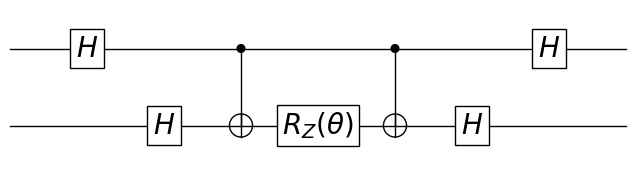

In [21]:
def plot_rxx():
    from sympy.physics.quantum.circuitplot import CircuitPlot, CreateOneQubitGate
    from sympy.physics.quantum.gate import CNOT, H
    from IPython.display import display, Latex

    RZ = CreateOneQubitGate("RZ", "R_Z(\\theta)")

    display(Latex(r"\text{Porta Quântica RXX}(\theta)"))
    CircuitPlot(H(1) * H(0) * CNOT(1, 0) * RZ(0) * CNOT(1, 0) * H(0) * H(1), 2)


plot_rxx()

In [22]:
def porta_rxx(theta: float, qubits: Quant):
    # Implemente a portas RXX(ϴ)
    ...

<IPython.core.display.Latex object>

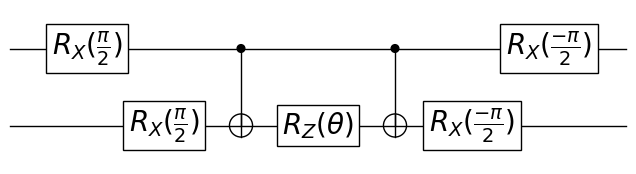

In [23]:
def plot_ryy():
    from sympy.physics.quantum.circuitplot import CircuitPlot, CreateOneQubitGate
    from sympy.physics.quantum.gate import CNOT
    from IPython.display import display, Latex

    RZ = CreateOneQubitGate("RZ", "R_Z(\\theta)")
    RX_PI_2 = CreateOneQubitGate("RX(π/2)", "R_X(\\frac{\\pi}{2})")
    RX_mPI_2 = CreateOneQubitGate("RX(-π/2)", "R_X(\\frac{-\\pi}{2})")

    display(Latex(r"\text{Porta Quântica RZZ}(\theta)"))
    CircuitPlot(
        RX_mPI_2(1)
        * RX_mPI_2(0)
        * CNOT(1, 0)
        * RZ(0)
        * CNOT(1, 0)
        * RX_PI_2(0)
        * RX_PI_2(1),
        2,
    )


plot_ryy()

In [24]:
def porta_ryy(theta: float, qubits: Quant):
    # Implemente a portas RYY(ϴ)
    ...

<IPython.core.display.Latex object>

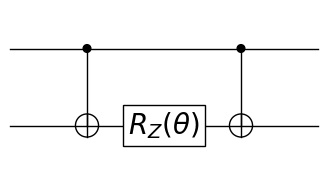

In [25]:
def plot_rzz():
    from sympy.physics.quantum.circuitplot import CircuitPlot, CreateOneQubitGate
    from sympy.physics.quantum.gate import CNOT, H
    from IPython.display import display, Latex

    RZ = CreateOneQubitGate("RZ", "R_Z(\\theta)")

    display(Latex(r"\text{Porta Quântica RZZ}(\theta)"))
    CircuitPlot(CNOT(1, 0) * RZ(0) * CNOT(1, 0), 2)


plot_rzz()

In [26]:
def porta_rzz(theta: float, qubits: Quant):
    # Implemente a portas RZZ(ϴ)
    ...

## Medidas

Após realizar os cálculos na computação quântica, é necessário extrair os resultados para o ambiente clássico. Isso é feito por meio de medidas nos qubits. Nesta seção, exploraremos diferentes formas de medir qubits no Ket.

### Extrair o Estado Quântico

Ao simularmos um computador quântico, como fazemos neste capítulo, não estamos restritos às limitações da mecânica quântica. Assim, podemos extrair todo o estado quântico do simulador para manipulá-lo dentro do Python. Para isso, utilizamos a função {func}`~ket.operations.dump`, que retorna uma instância de {class}`~ket.base.QuantumState`.

Com o objeto {class}`~ket.base.QuantumState`, é possível iterar sobre o estado quântico usando o atributo {attr}`~ket.base.QuantumState.states`. Neste atributo, o estado quântico é representado por um dicionário que mapeia o estado da base, representado por um número inteiro ({class}`int`), para sua amplitude de probabilidade associada, representada por um número complexo ({class}`complex`).

:::{warning}
A extração do {class}`~ket.base.QuantumState` só é possível quando estamos em um ambiente simulado. Além disso, o {class}`~ket.base.QuantumState` não tem a capacidade de representar estados mistos. Portanto, se o {class}`~ket.base.QuantumState` representar um qubit entrelaçado com um qubit que não pertence ao mesmo {class}`~ket.base.QuantumState`, a representação não será completa.

Tendo isso em mente, o uso da função {func}`~ket.operations.dump` é uma ótima maneira de testar e debugar uma execução quântica. No entanto, não é recomendado substituir uma medida por esta abordagem.
:::

Além do atributo {attr}`~ket.base.QuantumState.states`, é possível acessar o atributo {attr}`~ket.base.QuantumState.probabilities` para obter as probabilidades de medida. Também podemos utilizar o método {meth}`~ket.base.QuantumState.sample` para simular uma amostragem a partir do {class}`~ket.base.QuantumState`.

Abaixo, seguem exemplos de como utilizar a função {func}`~ket.operations.dump` para extrair o estado quântico e iterar sobre ele através do atributo {attr}`~ket.base.QuantumState.states`.

In [27]:
processo = Process()

qubits = processo.alloc(2)

# prepara estado de Bell
cat(kron(H, I), CNOT)(*qubits)

estado_quântico = dump(qubits)

for estado, amplitude in estado_quântico.states.items():
    print(f"{amplitude} |{estado}⟩")

(0.7071067811865476+0j) |0⟩
(0.7071067811865476+0j) |3⟩


Uma maneira alternativa de exibir o estado quântico é utilizando o método {meth}`~ket.base.QuantumState.show` da classe {class}`~ket.base.QuantumState`.

In [28]:
print(estado_quântico.show())

|00⟩	(50.00%)
 0.707107       	≅      1/√2
|11⟩	(50.00%)
 0.707107       	≅      1/√2


### Medição de Qubits

A função {func}`~ket.operations.measure` é utilizada para medir qubits na base computacional, resultando em um objeto do tipo {class}`~ket.base.Measurement`. Após a medição, o estado do qubit colapsa para o estado correspondente à medida realizada. Para extrair o resultado da medida, basta acessar o atributo {attr}`~ket.base.Measurement.value`, o qual retorna um número inteiro sem sinal. É importante observar que o qubit de índice 0 corresponde ao bit de maior magnitude no resultado final. Portanto, a medição dos qubits $\ket{\texttt{xyz}}$ resulta no número binário $\texttt{0b}\texttt{xyz}$.

Abaixo está um exemplo de uso da função {func}`~ket.operations.measure`. Neste exemplo, estamos medindo o primeiro qubit após a preparação do estado de Bell e exibindo o resultado da medida.

In [29]:
processo = Process()

qubits = processo.alloc(2)

# Preparando o estado de Bell
cat(kron(H, I), CNOT)(*qubits)

estado_quântico = dump(qubits)

print("Estado quântico antes da medida")
print_state(qubits)

medida = measure(qubits[0])
print("Resultado da medida do primeiro qubit:", medida.value)

print("Estado quântico após o colapso")
print_state(qubits)

Estado quântico antes da medida


<IPython.core.display.Math object>

Resultado da medida do primeiro qubit: 0
Estado quântico após o colapso


<IPython.core.display.Math object>

#### Exercício: Medidas em Outras Bases

Os computadores quânticos normalmente realizam medidas apenas na base computacional (base Z). No entanto, aplicando algumas operações quânticas, é possível realizar medidas em outras bases. Neste exercício, exploraremos medidas nas bases X e Y.

**Medidas na Base X (Hadamard):**

Na base X, também conhecida como base de Hadamard, a medida de um qubit no estado $\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$ retorna 0, e a medida no estado $\frac{1}{\sqrt{2}}(\ket{0}-\ket{1})$ retorna 1. Implemente as rotações necessárias nos qubits para efetuar uma medida na base computacional usando a função {func}`~ket.operations.measure`.



In [39]:
def medir_x(qubit: Quant) -> int: ...


def verificar_medir_x():
    processo = Process()

    a, b = processo.alloc(2)
    X(b)
    H(a + b)

    assert medir_x(a) == 0
    assert medir_x(b) == 1
    print("Verificação concluída com sucesso")


# verificar_medir_x()

**Medidas na Base Y:**

Na base Y, a medida de um qubit no estado $\frac{1}{\sqrt{2}}(\ket{0}+i\ket{1})$ retorna 0, e a medida no estado $\frac{1}{\sqrt{2}}(\ket{0}-i\ket{1})$ retorna 1. Implemente as rotações necessárias nos qubits para efetuar uma medida na base computacional usando a função {func}`~ket.operations.measure`.

In [43]:
def medir_y(qubit: Quant) -> int: ...


def verificar_medir_y():
    processo = Process()

    a, b = processo.alloc(2)
    X(b)
    S(H(a + b))

    assert medir_y(a) == 0
    assert medir_y(b) == 1
    print("Verificação concluída com sucesso")


# verificar_medir_y()

### Amostragem de Qubits

Muitos algoritmos quânticos dependem não apenas de uma medida exata, mas de uma distribuição de probabilidades. Portanto, é necessário executar várias medições em vez de apenas uma. Muitos computadores quânticos implementam esse comportamento, e o Ket oferece a função {func}`~ket.operations.sample`, que retorna uma instância de {class}`~ket.base.Samples` com os resultados das medições. Para acessar o resultado, basta ler o atributo {attr}`~ket.base.Samples.value`, que retorna um dicionário mapeando o estado medido ao número de vezes que esse estado foi observado.

:::{attention}
Nos simuladores padrão do Ket o estado quântico não é colapsado após a chamada da função {func}`~ket.operations.sample`, e os qubits permanecem disponíveis para outras operações. No entanto, esse comportamento não é garantido em computadores quânticos reais, onde os qubits normalmente se tornam indisponíveis após a medição.
:::

A seguir, apresentamos um exemplo de uso da função {func}`~ket.operations.sample`:

In [32]:
processo = Process()

qubits = processo.alloc(2)

# Preparando o estado de Bell
cat(kron(H, I), CNOT)(*qubits)

estado_quântico = dump(qubits)

print("Estado quântico")
print_state(qubits, format="int")

medida = sample(qubits)
print("Resultado das medidas:", medida.value)

Estado quântico


<IPython.core.display.Math object>

Resultado das medidas: {0: 1016, 3: 1032}



### Calcular Valor Esperado

## Execução Quântica e Simulação    

### Modos de Execução Quântica

### Configuração do Processo e dos Simuladores